In [ ]:
# Harsh Hegde

In [ ]:
#packages imported
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge
import warnings
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
sns.set_style("white")
from sklearn.metrics import matthews_corrcoef

%store -r

In [ ]:
!pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
!pip install category-encoders



     |████████████████████████████████| 86 kB 3.0 MB/s 


In [ ]:
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectKBest

# Models
from sklearn.svm import SVC

# Model Selection functions
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support as score

# Others
import time
from sklearn.utils import resample
import scipy.interpolate

import seaborn as sns
import matplotlib
%matplotlib inline

sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (6, 3)


# Functions

In [ ]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):   #function to plot the confusion matrix
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    plt.title(title)
    plt.ylabel('True heart disease')
    plt.xlabel('Predicted heart disease')

In [ ]:
def evaluate_model(model, X_test, y_test):  #function to do the model evaluation
    assert len(X_test) == len(y_test), "X_test and y_test are not equal in size."

    # Predict Test Data 
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average='macro')
    rec = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_prob = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = metrics.roc_auc_score(y_test, y_pred_prob)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print('Kappa:', kappa)
    #print('Confusion Matrix:\n', knn_eval['confusion-matrix'])
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC: {round(auc, 2)}')
    plt.legend()
    plt.show()
    
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cm_norm, title='Confusion matrix')
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'F1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'area': auc, 'confusion-matrix': cm}

#Preprocessing

In [ ]:
#Read file
df = pd.read_csv('heart_2020_cleaned.csv')

#Replace non-numeric answers
df =  df[df.columns].replace({'Yes':1, 'No':0, 'Male':1,'Female':0,'No, borderline diabetes':'0','Yes (during pregnancy)':'1' })
df['Diabetic'] = df['Diabetic'].astype(int)
binary_cols = ['HeartDisease','Sex','Smoking','AlcoholDrinking','Stroke','Asthma', 'DiffWalking','PhysicalActivity','KidneyDisease','SkinCancer']

#Standardize
num_cols = ['MentalHealth', 'BMI', 'PhysicalHealth', 'SleepTime']
Scaler = StandardScaler()
df[num_cols] = Scaler.fit_transform(df[num_cols])
df = pd.get_dummies(df, columns = ['AgeCategory', 'Race',  'Diabetic', 'GenHealth'])

#Seed value
Seed = 42

#Split data
x = df.drop(columns = ['HeartDisease'], axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle = True, test_size = 0.2, random_state = Seed)

print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

df

Shape of training feature: (255836, 39)
Shape of testing feature: (63959, 39)
Shape of training label: (255836,)
Shape of training label: (63959,)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_Hispanic,Race_Other,Race_White,Diabetic_0,Diabetic_1,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,-1.844750,1,0,0,-0.046751,3.281069,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,-1.256338,0,0,1,-0.424070,-0.490039,0,0,1,...,0,0,1,1,0,0,0,0,0,1
2,0,-0.274603,1,0,0,2.091388,3.281069,0,1,1,...,0,0,1,0,1,0,1,0,0,0
3,0,-0.647473,0,0,0,-0.424070,-0.490039,0,0,0,...,0,0,1,1,0,0,0,1,0,0
4,0,-0.726138,0,0,0,3.097572,-0.490039,1,0,1,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,-0.144019,1,0,0,0.456341,-0.490039,1,1,0,...,1,0,0,0,1,0,1,0,0,0
319791,0,0.238291,1,0,0,-0.424070,-0.490039,0,1,1,...,1,0,0,1,0,0,0,0,0,1
319792,0,-0.642753,0,0,0,-0.424070,-0.490039,0,0,1,...,1,0,0,1,0,0,0,1,0,0
319793,0,0.705560,0,0,0,-0.424070,-0.490039,0,0,0,...,1,0,0,1,0,0,0,1,0,0


# Cross Validation

In [ ]:
#Implementing cross validation using k fold of 5
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
acc_score = []
 
for train_index , test_index in kf.split(x):
    X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.9130536750105537, 0.9162901233602777, 0.9184008505448803, 0.9143826513860441, 0.9173220344283056]
Avg accuracy : 0.9158898669460124


# Exploratory Analysis

In [ ]:
#importing the data without modification for preliminary visualisations
ds = pd.read_csv('heart_2020_cleaned.csv')
ds_cat = ds.select_dtypes(include="object")

ds

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [ ]:
#categorise data by age
ds1 = ds.sort_values(by = 'AgeCategory' , ascending = True)
ds1

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
289336,No,21.83,No,No,No,20.0,8.0,No,Male,18-24,Other,No,Yes,Excellent,8.0,No,No,No
92977,No,21.14,No,No,No,0.0,0.0,No,Female,18-24,White,No,Yes,Excellent,9.0,No,No,No
228704,No,20.81,No,No,No,0.0,10.0,No,Female,18-24,White,No,Yes,Excellent,7.0,Yes,No,No
49749,No,20.84,Yes,No,No,0.0,3.0,No,Male,18-24,Asian,No,No,Good,10.0,No,No,No
49753,No,24.33,No,No,No,0.0,0.0,No,Male,18-24,Hispanic,No,Yes,Excellent,7.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261373,No,30.23,Yes,No,No,0.0,0.0,No,Male,80 or older,Hispanic,No,Yes,Excellent,10.0,No,No,No
203667,No,25.83,No,No,No,0.0,3.0,No,Male,80 or older,White,No,Yes,Very good,7.0,No,No,No
261380,Yes,20.92,Yes,No,No,0.0,0.0,No,Male,80 or older,White,No,Yes,Fair,8.0,No,No,No
261449,No,22.31,No,No,No,3.0,0.0,No,Male,80 or older,Hispanic,No,No,Fair,9.0,No,No,No


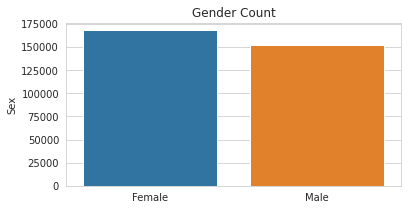

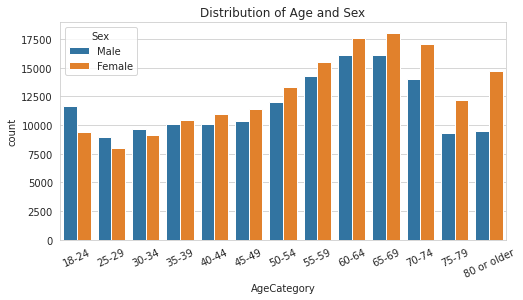

In [ ]:
# data visualization for gender and age
gender_counts = ds.Sex.value_counts()
gender_counts
plt.title('Gender Count')
sns.barplot(x=gender_counts.index , y = gender_counts);


plt.figure(figsize = (8,4))
plt.title('Distribution of Age and Sex')
plt.xticks(rotation = 25)
sns.countplot(x = 'AgeCategory' ,hue='Sex' , data = ds1 );

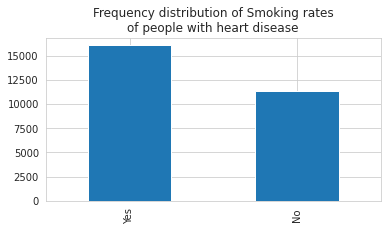

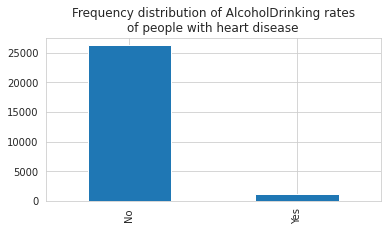

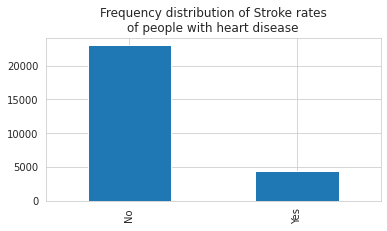

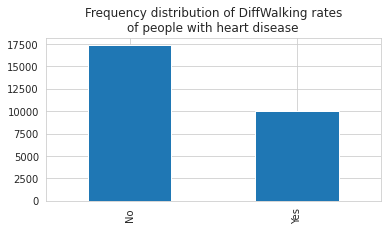

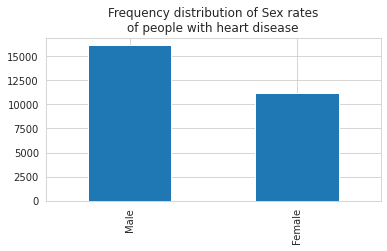

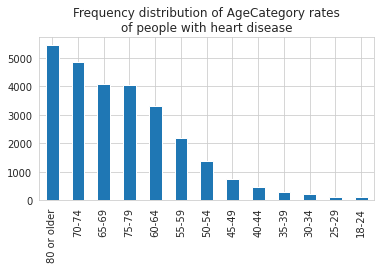

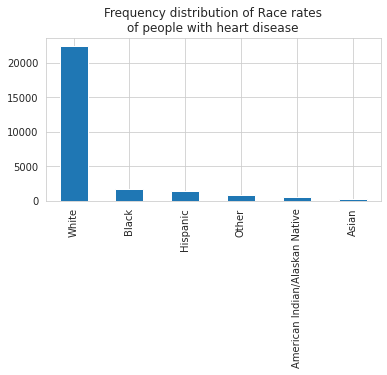

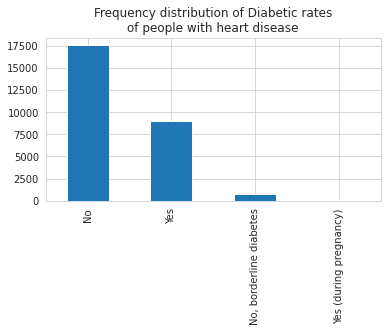

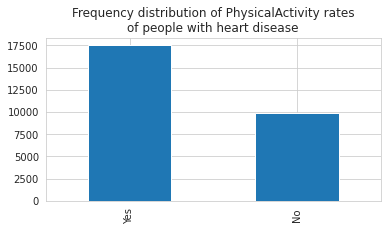

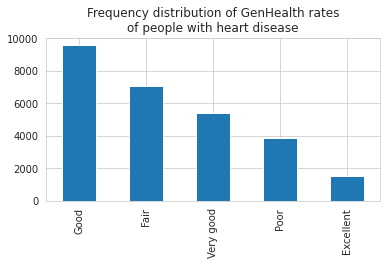

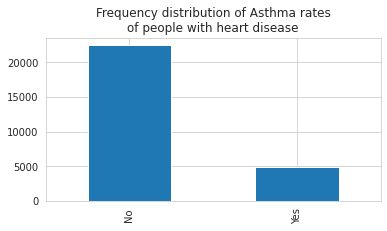

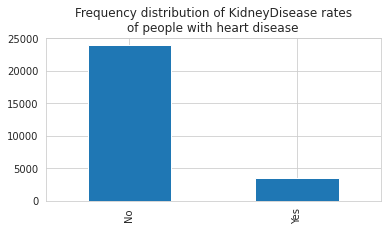

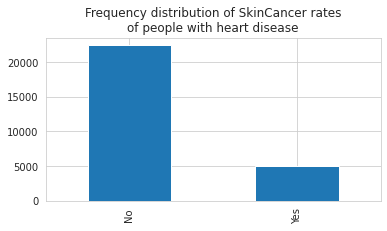

In [ ]:
# data visualization for each non numberical [arameter with respect to heart diseases
for col in ds_cat.columns[1:]:
    fig, ax = plt.subplots()
    ds[col][ds_cat["HeartDisease"] == "Yes"].value_counts().plot.bar()
    plt.title(f"Frequency distribution of {col} rates\n"
              f"of people with heart disease")

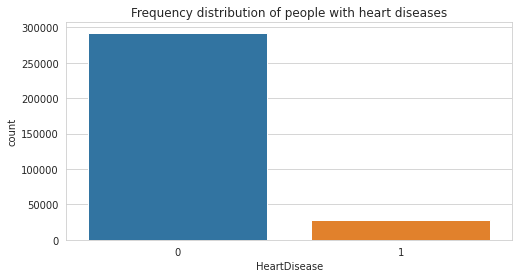

In [ ]:
#Frequency Distribution of people with heart diseases
plt.figure(figsize=(8, 4))
plt.title("Frequency distribution of people with heart diseases")
sns.countplot(x = 'HeartDisease', data = ds)


# Correlation Feature Selection

In [ ]:
# Finding the correlation between the parameters and heart diseases
cols = df.columns
corr = []
for col in cols:
    if col in binary_cols:
        corr.append(matthews_corrcoef(df['HeartDisease'], df[col]))
    else:
        corr.append(df['HeartDisease'].corr(df[col]))
correlation = pd.DataFrame(list(zip(cols, corr)), columns=['Variables','Corr_with_HeartDisease'])
correlation.drop(index=correlation.index[:1], axis=0, inplace=True)
correlation
    

,Variables,Corr_with_HeartDisease
1,BMI,0.051803
2,Smoking,0.107764
3,AlcoholDrinking,-0.032080
4,Stroke,0.196835
5,PhysicalHealth,0.170721
6,MentalHealth,0.028591
7,DiffWalking,0.201258
8,Sex,0.070040
9,PhysicalActivity,-0.100030
10,SleepTime,0.008327


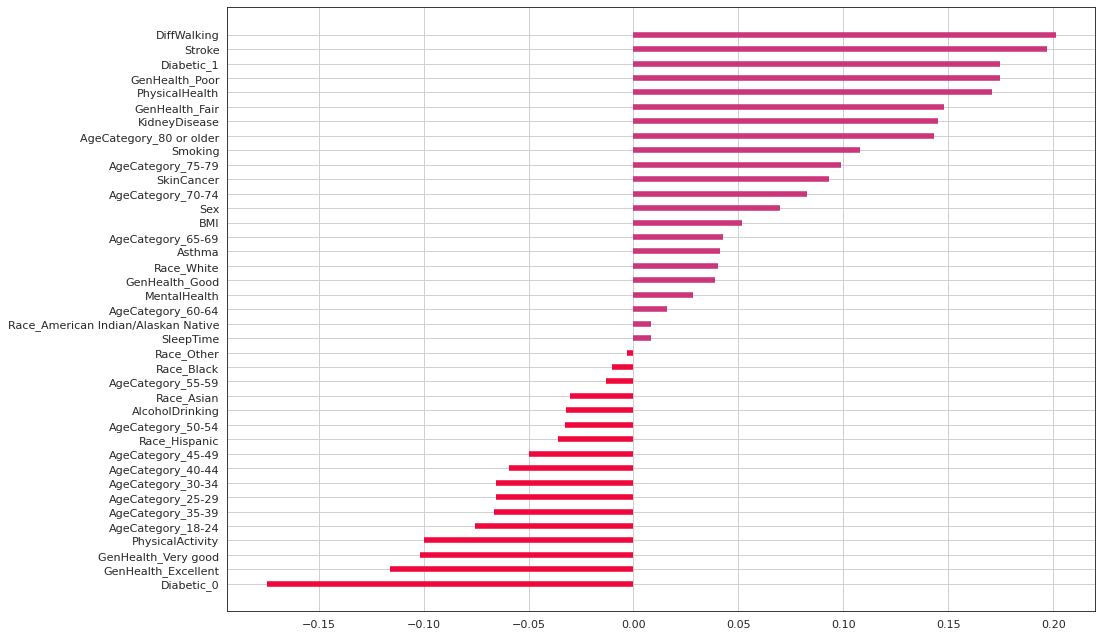

In [ ]:
# Plotting the correlation
for i in range(len(correlation)):
    # Colour of bar chart is set to red if corr is < 0 and green otherwise
    correlation['colors'] = ['#F0073B' if float(x) <= 0 else '#CB3579' for x in correlation['Corr_with_HeartDisease']]
correlation = correlation.sort_values(ascending=True, by=['Corr_with_HeartDisease']) 
plt.figure(figsize=(14,10), dpi=80)
plt.hlines(y=correlation.Variables, xmin=0, xmax=correlation.Corr_with_HeartDisease, color=correlation.colors,  linewidth=5)
plt.grid()
plt.show()

#SVM

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=125).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.91      0.89      0.90     58367
           1       0.06      0.07      0.06      5592

    accuracy                           0.82     63959
   macro avg       0.48      0.48      0.48     63959
weighted avg       0.83      0.82      0.83     63959

Kappa: -0.03656989899949803


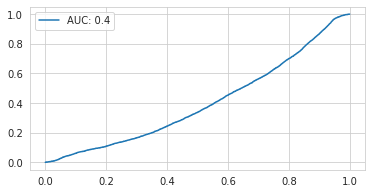

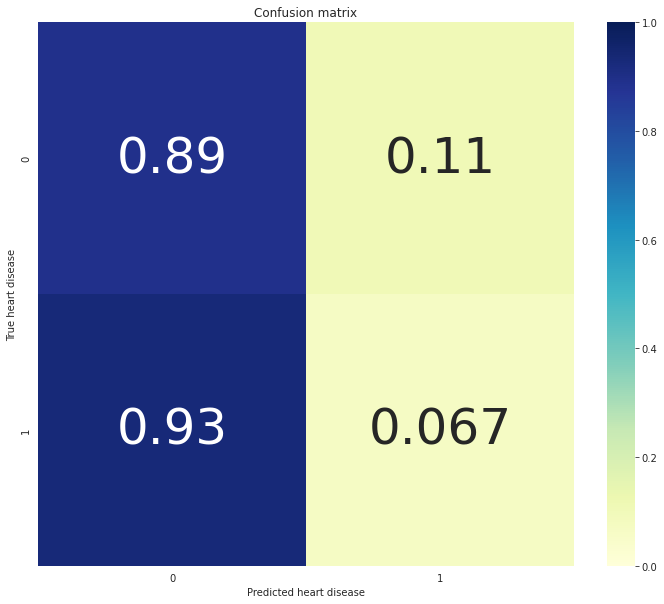

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     58367
           1       0.06      0.00      0.00      5592

    accuracy                           0.91     63959
   macro avg       0.48      0.50      0.48     63959
weighted avg       0.84      0.91      0.87     63959

Kappa: -0.00020466320115097858


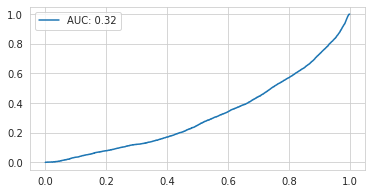

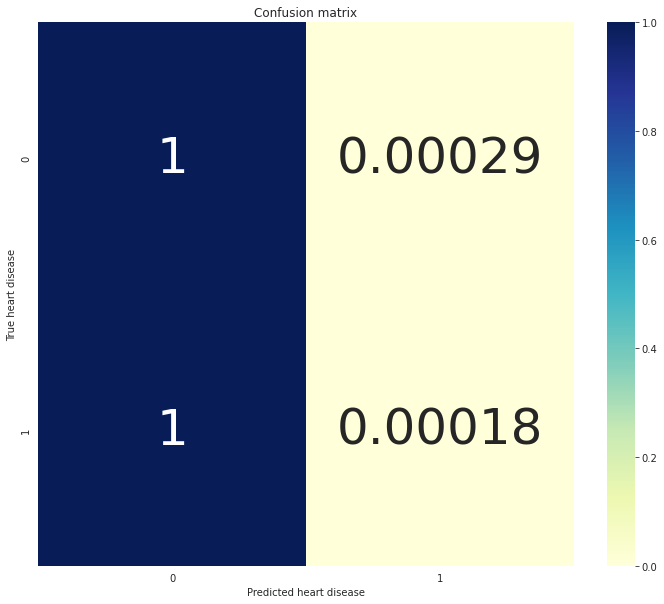

{'F1': 0.4772525246306963,
 'accuracy': 0.9123188292499883,
 'area': 0.32046618563466484,
 'confusion-matrix': array([[58350,    17],
        [ 5591,     1]]),
 'fpr': array([0.00000000e+00, 1.71329690e-05, 2.05595628e-04, ...,
        9.99931468e-01, 9.99931468e-01, 1.00000000e+00]),
 'kappa': -0.00020466320115097858,
 'precision': 0.48405778591027493,
 'recall': 0.49994378321151894,
 'tpr': array([0.        , 0.        , 0.        , ..., 0.99982117, 1.        ,
        1.        ])}

In [ ]:
# Create Model using pipeline to combine preprocess with SVC and parameters 
model = make_pipeline(StandardScaler(), SVC(kernel = "rbf", gamma="scale", max_iter = 125, probability = True))
svm_fit = model.fit(X_train, y_train)

# Call evaluate function and display connfusion matrix
evaluate_model(svm_fit, X_test, y_test)


# Create SVM with Balanced Class Weighting
model = make_pipeline(StandardScaler(), SVC(kernel = "rbf", gamma="scale",class_weight = "balanced", max_iter = 500, probability = True))
svm_fit = model.fit(X_train, y_train)

# Unbalanced Results
evaluate_model(svm_fit, X_test, y_test)



#KNN

Running KNN for K = 2
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.32      0.06      0.10      5592

    accuracy                           0.91     63959
   macro avg       0.62      0.52      0.53     63959
weighted avg       0.86      0.91      0.88     63959

Kappa: 0.07812555060873849


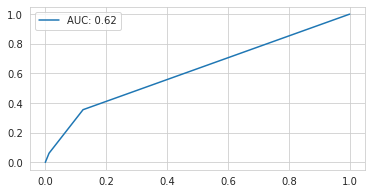

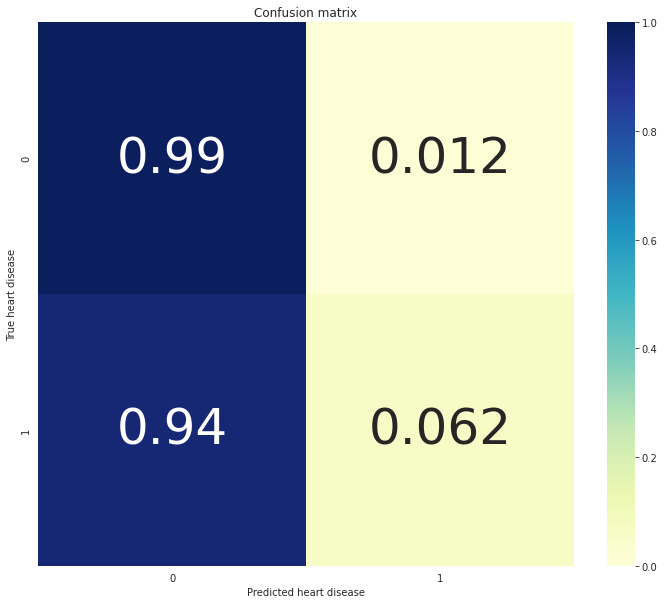

Running KNN for K = 3
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     58367
           1       0.30      0.14      0.20      5592

    accuracy                           0.90     63959
   macro avg       0.61      0.56      0.57     63959
weighted avg       0.87      0.90      0.88     63959

Kappa: 0.14749214608057448


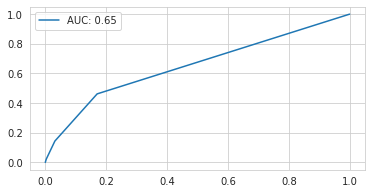

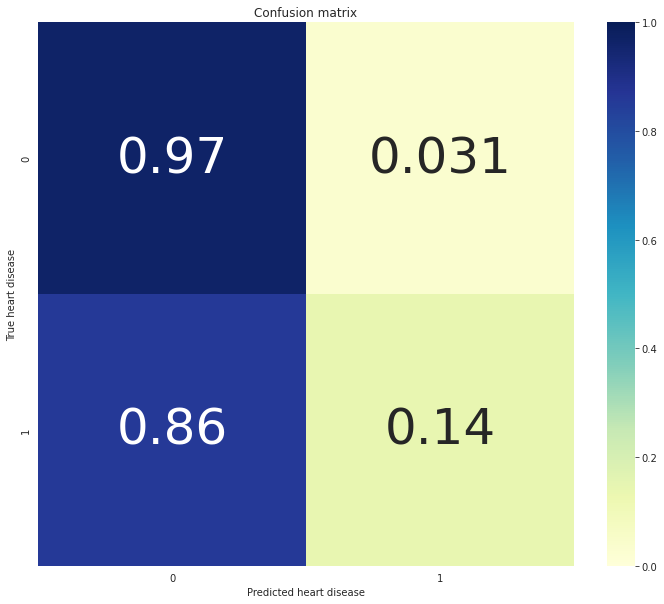

Running KNN for K = 4
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.37      0.06      0.11      5592

    accuracy                           0.91     63959
   macro avg       0.64      0.53      0.53     63959
weighted avg       0.87      0.91      0.88     63959

Kappa: 0.08243272360484466


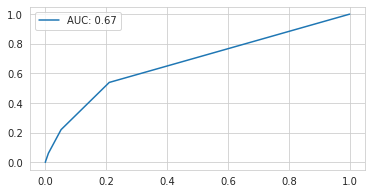

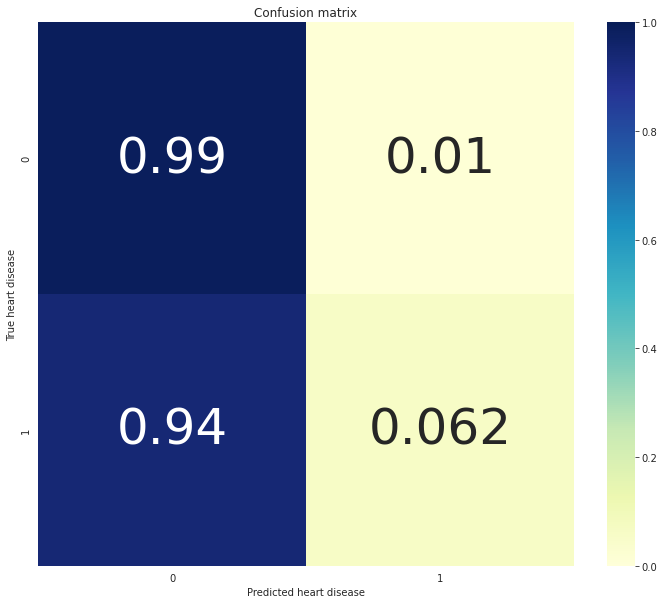

Running KNN for K = 5
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     58367
           1       0.35      0.11      0.17      5592

    accuracy                           0.90     63959
   macro avg       0.64      0.55      0.56     63959
weighted avg       0.87      0.90      0.88     63959

Kappa: 0.13286612880214532


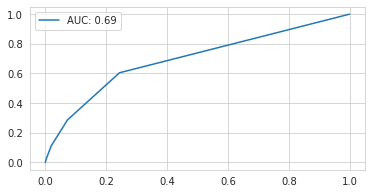

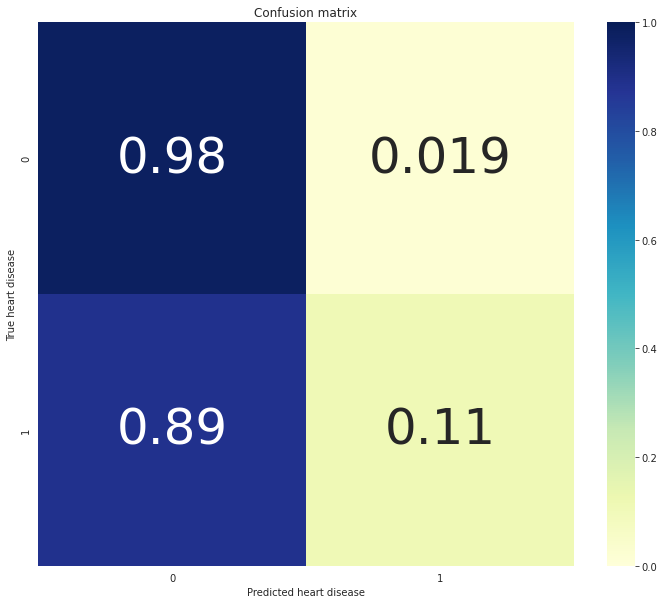

Running KNN for K = 6
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.39      0.05      0.09      5592

    accuracy                           0.91     63959
   macro avg       0.65      0.52      0.52     63959
weighted avg       0.87      0.91      0.88     63959

Kappa: 0.0748209397181212


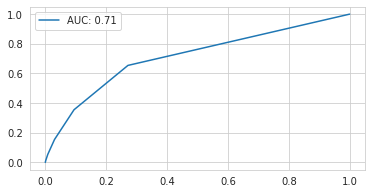

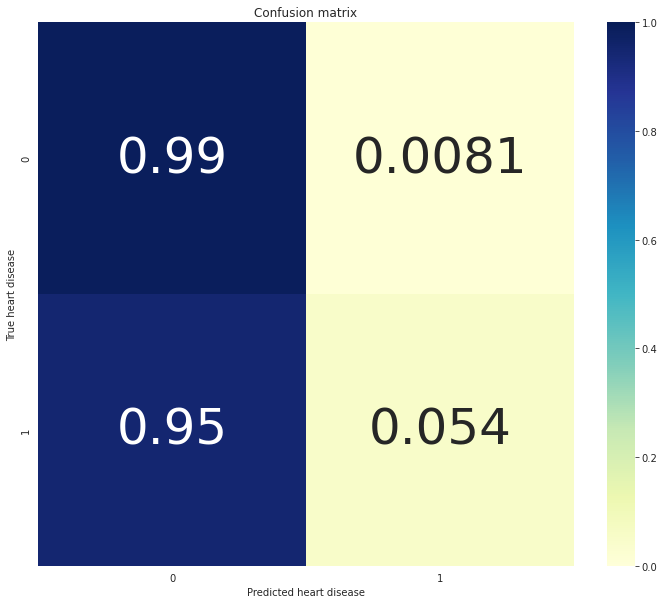

Running KNN for K = 7
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.36      0.08      0.14      5592

    accuracy                           0.91     63959
   macro avg       0.64      0.53      0.54     63959
weighted avg       0.87      0.91      0.88     63959

Kappa: 0.10652193140338628


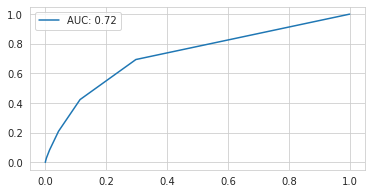

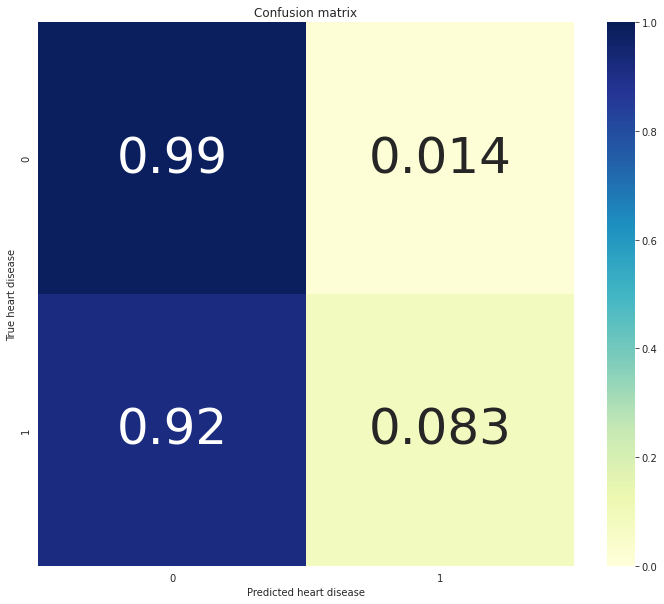

Running KNN for K = 8
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.42      0.05      0.09      5592

    accuracy                           0.91     63959
   macro avg       0.67      0.52      0.52     63959
weighted avg       0.87      0.91      0.88     63959

Kappa: 0.07258383243420885


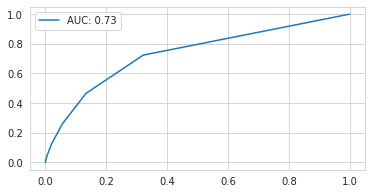

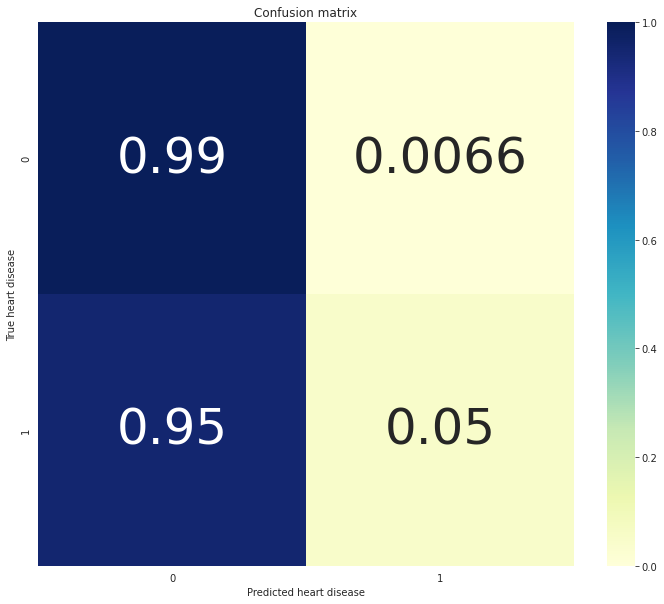

In [ ]:
# Running KNN for K values from K = 2 to 9
for k in range(2,9):
  print("Running KNN for K =", k)
  
  #Create model
  knn = KNeighborsClassifier(n_neighbors = k)
  
  #Fit Model
  knn.fit(X_train, y_train)
  
  #Evaluate Model
  knn_eval = evaluate_model(knn, X_test, y_test)

 #  Logistic Regression

Unbalanced Data

In [ ]:
# Logistic Regression on unbalanced data
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959

Kappa: 0.14562832600206943


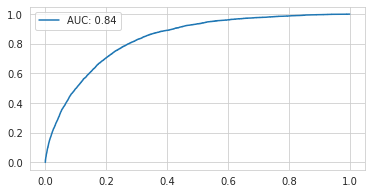

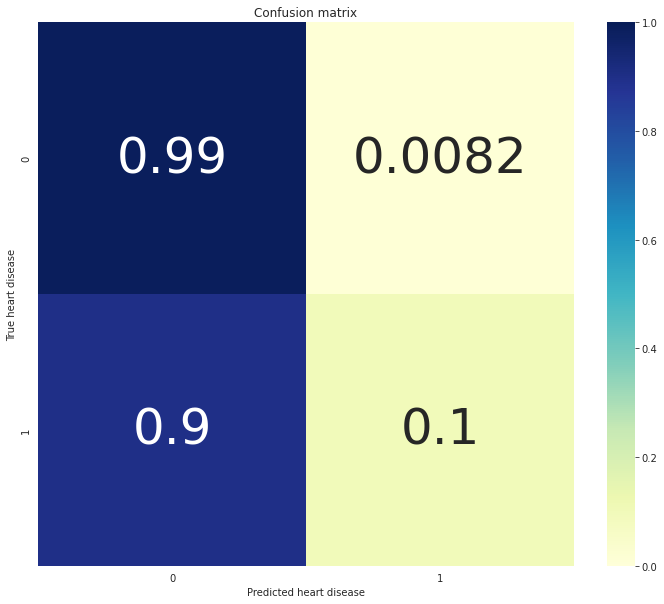

{'F1': 0.5617841307931289,
 'accuracy': 0.9138823308682125,
 'area': 0.8364466851663515,
 'confusion-matrix': array([[57891,   476],
        [ 5032,   560]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99593949, 0.99597375,
        1.        ]),
 'kappa': 0.14562832600206943,
 'precision': 0.7302848913150393,
 'recall': 0.5459938841428441,
 'tpr': array([0.00000000e+00, 1.78826896e-04, 7.15307582e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}

In [ ]:
# Calling the function to plot the results
evaluate_model(lr, X_test, y_test)


In [ ]:
# printing the accuracy
print('The training accuracy is', lr.score(X_train, y_train))
print('The test accuracy is', lr.score(X_test, y_test))

The training accuracy is 0.9164933785706468
The test accuracy is 0.9138823308682125


Balanced Data

In [ ]:
# Logistic Regression on balanced data

lr_bal = LogisticRegression(max_iter=500, class_weight= "balanced")
lr_bal.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=500)

              precision    recall  f1-score   support

           0       0.97      0.75      0.84     58367
           1       0.23      0.78      0.35      5592

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.80     63959

Kappa: 0.24976834427494043


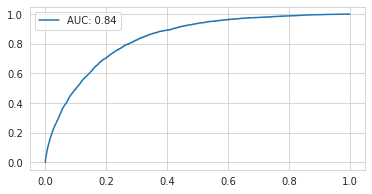

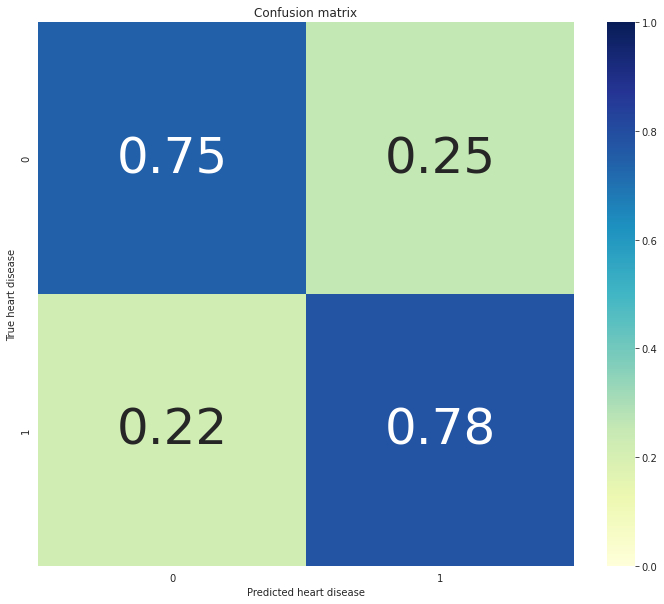

{'F1': 0.5977404160704866,
 'accuracy': 0.7486514798542816,
 'area': 0.8370410325170271,
 'confusion-matrix': array([[43529, 14838],
        [ 1238,  4354]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99696746, 0.99700173,
        1.        ]),
 'kappa': 0.24976834427494043,
 'precision': 0.5996055308206776,
 'recall': 0.7621966548405061,
 'tpr': array([0.00000000e+00, 1.78826896e-04, 7.15307582e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}

In [ ]:
evaluate_model(lr_bal, X_test, y_test)

In [ ]:
print('The training accuracy is', lr_bal.score(X_train, y_train))
print('The test accuracy is', lr_bal.score(X_test, y_test))

The training accuracy is 0.7501133538673213
The test accuracy is 0.7486514798542816


Undersampled

In [ ]:
# Logistic Regression using undersampling

from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy="majority")
X_under, y_under = undersample.fit_resample(x, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
lr_us = LogisticRegression(max_iter=500)
lr_us.fit(X_train, y_train)

print('The training accuracy is', lr_us.score(X_train, y_train))
print('The test accuracy is', lr_us.score(X_test, y_test))


The training accuracy is 0.7647730386336652
The test accuracy is 0.7617351598173516


              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5434
           1       0.76      0.78      0.77      5516

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950

Kappa: 0.5233307964190165


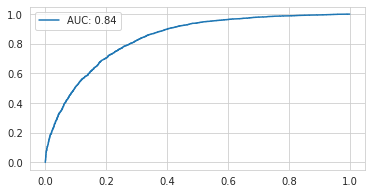

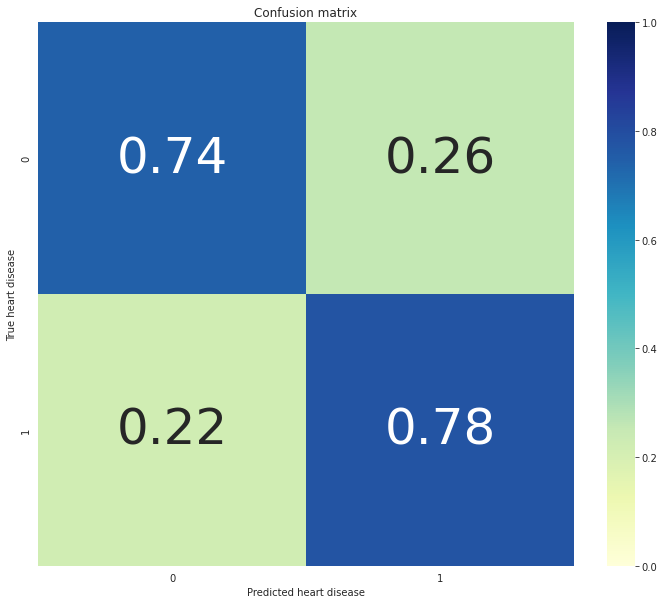

{'F1': 0.7616058749568948,
 'accuracy': 0.7617351598173516,
 'area': 0.839343931515986,
 'confusion-matrix': array([[4043, 1391],
        [1218, 4298]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99245491, 0.99245491,
        1.        ]),
 'kappa': 0.5233307964190165,
 'precision': 0.7619890678292882,
 'recall': 0.7616034780074321,
 'tpr': array([0.00000000e+00, 1.81290790e-04, 9.06453952e-04, ...,
        9.99818709e-01, 1.00000000e+00, 1.00000000e+00])}

In [ ]:
evaluate_model(lr_us, X_test, y_test)


Undersampled Balanced

In [ ]:
# Logistic Regression on balanced data using undersampling

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
lr_us = LogisticRegression(max_iter=500, class_weight = "balanced")
lr_us.fit(X_train, y_train)

print('The training accuracy is', lr_us.score(X_train, y_train))
print('The test accuracy is', lr_us.score(X_test, y_test))

The training accuracy is 0.7673531829390812
The test accuracy is 0.7631050228310502


              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5434
           1       0.76      0.78      0.77      5516

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950

Kappa: 0.5260693793463204


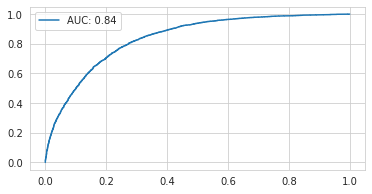

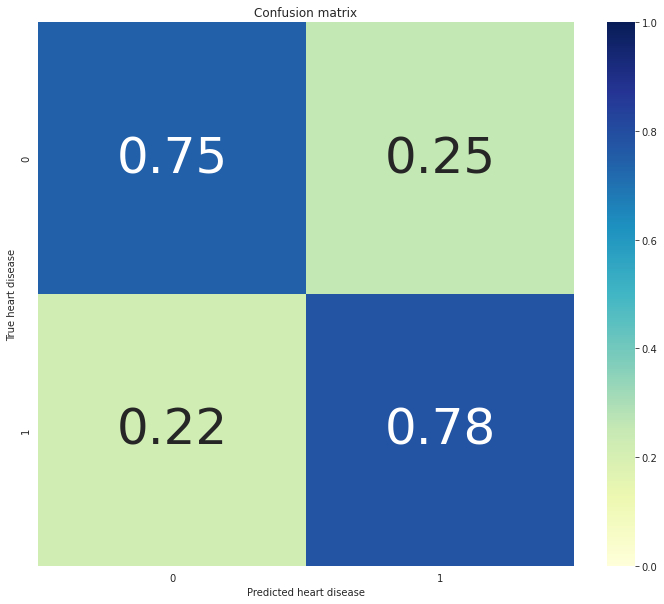

{'F1': 0.7629734372834539,
 'accuracy': 0.7631050228310502,
 'area': 0.8383989607774005,
 'confusion-matrix': array([[4049, 1385],
        [1209, 4307]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99411115, 0.99411115,
        1.        ]),
 'kappa': 0.5260693793463204,
 'precision': 0.7633703499563093,
 'recall': 0.7629713660638053,
 'tpr': array([0.00000000e+00, 1.81290790e-04, 9.42712110e-03, ...,
        9.99818709e-01, 1.00000000e+00, 1.00000000e+00])}

In [ ]:
evaluate_model(lr_us, X_test, y_test)


In [ ]:
print('The training accuracy is', lr_us.score(X_train, y_train))
print('The test accuracy is', lr_us.score(X_test, y_test))

The training accuracy is 0.7649328705817883
The test accuracy is 0.7661187214611872


# Balancing the data initially

In [ ]:

# Balancing the data initially
class_0 = df[df['HeartDisease'] == 0]
class_1 = df[df['HeartDisease'] == 1]

class_1 = class_1.sample(len(class_0),replace=True)
df = pd.concat([class_0, class_1], axis=0)
print('Data in Train:')
print(df['HeartDisease'].value_counts())

Data in Train:
0    292422
1    292422
Name: HeartDisease, dtype: int64


In [ ]:
x = df.drop(columns = ['HeartDisease'], axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle = True, test_size = 0.2, random_state = Seed)


In [ ]:
# Create LogisticRegression
lr_bal2 = LogisticRegression(max_iter=500, random_state=Seed)
lr_bal2.fit(X_train, y_train)
lr_y_predict = lr_bal2.predict(X_test)


              precision    recall  f1-score   support

           0       0.77      0.74      0.76     58529
           1       0.75      0.78      0.77     58440

    accuracy                           0.76    116969
   macro avg       0.76      0.76      0.76    116969
weighted avg       0.76      0.76      0.76    116969

Kappa: 0.5272732925746229


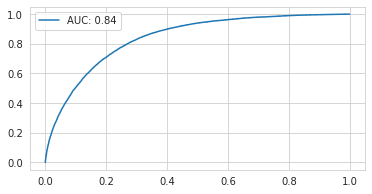

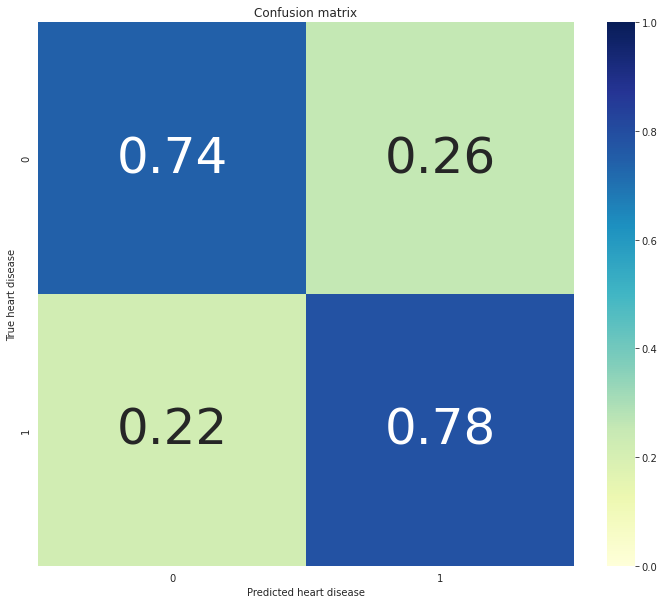

{'F1': 0.7635444275526938,
 'accuracy': 0.763629679658713,
 'area': 0.8401633250271379,
 'confusion-matrix': array([[43550, 14979],
        [12669, 45771]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99808642, 0.99808642,
        1.        ]),
 'kappa': 0.5272732925746229,
 'precision': 0.7640406193679523,
 'recall': 0.7636445694114042,
 'tpr': array([0.00000000e+00, 5.13347023e-05, 8.55578371e-05, ...,
        9.99948665e-01, 1.00000000e+00, 1.00000000e+00])}

In [ ]:
evaluate_model(lr_bal2, X_test, y_test)
